In [1]:
import warnings 
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm

In [6]:
import pandas as pd
import numpy as np
import random

#import pyLDAvis
#import pyLDAvis.gensim_models

In [8]:
import nltk
nltk.download('all')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\farah\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\farah\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\farah\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     C:\Users\farah\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\farah\AppData\Roaming\nltk_data...
[

In [14]:
#libraries regarding topic modelling
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore

from gensim.models import CoherenceModel
from gensim import matutils

In [15]:
df_car = pd.read_csv('car_5_brands.csv')
df_car

,Unnamed: 0,Rating,car_year,brand_name,date,review
0,0,5.00,2018,Audi,2018-07-11,BEST ALL AROUND PURPOSE CROSSOVER SUV I have n...
1,1,5.00,2018,Audi,2018-06-24,Best car This is a wonderful car. The technol...
2,2,5.00,2018,Audi,2018-05-02,Great Buy Do your home work
3,3,5.00,2018,Audi,2017-12-07,Fun Car Great ride. Loaded with technology. St...
4,4,5.00,2018,Audi,2017-10-25,Best luxury SUV w/ perfect comfort/sport balan...
...,...,...,...,...,...,...
31933,31933,4.75,2015,Mercedes-Benz,2015-06-04,One week in but I love it. I just got the car...
31934,31934,4.00,2015,Mercedes-Benz,2015-05-19,A delightful car I have been driving the GLA25...
31935,31935,3.00,2015,Mercedes-Benz,2015-02-21,This car is amazing but visibility is poor We ...
31936,31936,2.75,2015,Mercedes-Benz,2015-01-20,Steering Wheel Module When I first bought this...


In [16]:
sia = SentimentIntensityAnalyzer()

def sentimenter(x) :
  result = sia.polarity_scores(x)
  return result

In [17]:
''' we have classified sentiments based on compound score & we have decided tweak the limits a bit. '''
df_car['sentiment score'] = df_car['review'].apply(sentimenter)
def sent_score_string(x):
  if (x['compound']>= 0.05):
    return 'positive'
  elif (x['compound']> -0.05 and x['compound']< 0.05) :
    return 'neutral'
  elif (x['compound'] <= -0.05):
    return 'negative'

df_car['relative sentiments'] = df_car['sentiment score'].apply(sent_score_string)

In [18]:
# Count occurrences of each sentiment
sentiment_counts = df_car['relative sentiments'].value_counts()

# Print the result
print(sentiment_counts)


relative sentiments
positive    26578
negative     4465
neutral       895
Name: count, dtype: int64


In [19]:
df_car.brand_name.value_counts()

brand_name
BMW              8060
Mercedes-Benz    7375
Lexus            6153
Audi             6043
INFINITI         4307
Name: count, dtype: int64

In [20]:
stop_words = list(stopwords.words('english'))

In [21]:
stop_words.extend(['porsche,' 'mercede','comfortsport', 'mercedes','mercedes-benz', 'honda','toyota','audi', 'benz','bentley','lexus',
                  'nissan','volvo','drive','nt','like','vehicle','infiniti','good','miles','corvette','come','edmund','lotus','diego','snake',
                 'porsche', 'cayman','bought','year','minute','chicago','car','home', 'work','think','suv','people','edmunds',
                  'cabriolet','lexuss','japan','husband','baby','range', 'rover','cadillac','cadillacs','michelin','texas','second',
                   'awsome','one','now', 'take', 'give', 'new','levinson','road','love','sedan','wife','sport','bang','tank',
                   'truck','lemon','imho','pathfinder','infinity','convertible','allroad','conv','bike','ski','grocery','mclass'
                  ,'hardtop','club','hubby','child','zoom','test','etc','brain','ashamed','carmax','alpina','rocketship','great','germany',
                  'autobahn','mercedez','bmw'])

In [22]:
df_car.review

0        BEST ALL AROUND PURPOSE CROSSOVER SUV I have n...
1        Best car This is a wonderful car.  The technol...
2                              Great Buy Do your home work
3        Fun Car Great ride. Loaded with technology. St...
4        Best luxury SUV w/ perfect comfort/sport balan...
                               ...                        
31933    One week in but I love it.  I just got the car...
31934    A delightful car I have been driving the GLA25...
31935    This car is amazing but visibility is poor We ...
31936    Steering Wheel Module When I first bought this...
31937    Fun crossover/hatchback but not an SUV. I've h...
Name: review, Length: 31938, dtype: object

In [23]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

In [24]:
def tokenisation_pos_stopword_lemmatize(x):
  ''' This function was created to tokenise,POS tagging, Remove Stopwords & then lemmatise the Reviews. '''
  tokens = nltk.word_tokenize(x)
  #print (nltk.pos_tag(tokens))
  #POS-tagging
  tags = nltk.pos_tag(tokens)
  pos_tags_words = [t for t in tags if t[1] in["JJ","JJR","JJS","NN","NNP","NNS","NNPS","VB", "VBD" ,"VBG" ,"VBN" ,"VBP", "VBZ"] ]
  #stop-word removal
  filtered_words = [t[0] for t in pos_tags_words]
  filtered_words2 = [w for w in filtered_words if not w.lower() in stop_words]
  #lemmatization with lowercase function
  lemmatized_output = [lemmatizer.lemmatize(w).lower() for w in filtered_words2]
  return lemmatized_output

In [25]:
#review cleaned column after tokenize, remove stopword and lemmatize
df_car['review_cleaned'] = df_car['review'].apply(tokenisation_pos_stopword_lemmatize)


In [26]:
df_car = df_car.reset_index()
df_car.drop('index',axis=1,inplace=True)
#df_car.to_csv('C:/Users/farah/Downloads/fypdataset/delete.csv')
df_car

,Unnamed: 0,Rating,car_year,brand_name,date,review,sentiment score,relative sentiments,review_cleaned
0,0,5.00,2018,Audi,2018-07-11,BEST ALL AROUND PURPOSE CROSSOVER SUV I have n...,"{'neg': 0.026, 'neu': 0.815, 'pos': 0.16, 'com...",positive,"[around, purpose, crossover, seen, driven, 've..."
1,1,5.00,2018,Audi,2018-06-24,Best car This is a wonderful car. The technol...,"{'neg': 0.0, 'neu': 0.545, 'pos': 0.455, 'comp...",positive,"[best, wonderful, technology, adaptable, comfo..."
2,2,5.00,2018,Audi,2018-05-02,Great Buy Do your home work,"{'neg': 0.0, 'neu': 0.549, 'pos': 0.451, 'comp...",positive,[buy]
3,3,5.00,2018,Audi,2017-12-07,Fun Car Great ride. Loaded with technology. St...,"{'neg': 0.0, 'neu': 0.598, 'pos': 0.402, 'comp...",positive,"[fun, ride, loaded, technology, steering, tigh..."
4,4,5.00,2018,Audi,2017-10-25,Best luxury SUV w/ perfect comfort/sport balan...,"{'neg': 0.02, 'neu': 0.811, 'pos': 0.169, 'com...",positive,"[best, luxury, w/, perfect, comfort/sport, bal..."
...,...,...,...,...,...,...,...,...,...
31933,31933,4.75,2015,Mercedes-Benz,2015-06-04,One week in but I love it. I just got the car...,"{'neg': 0.044, 'neu': 0.617, 'pos': 0.339, 'co...",positive,"[week, got, procrastinating, couple, week, loo..."
31934,31934,4.00,2015,Mercedes-Benz,2015-05-19,A delightful car I have been driving the GLA25...,"{'neg': 0.111, 'neu': 0.771, 'pos': 0.118, 'co...",positive,"[delightful, driving, gla250, half, problem, p..."
31935,31935,3.00,2015,Mercedes-Benz,2015-02-21,This car is amazing but visibility is poor We ...,"{'neg': 0.041, 'neu': 0.729, 'pos': 0.23, 'com...",positive,"[amazing, visibility, poor, rear, window, chan..."
31936,31936,2.75,2015,Mercedes-Benz,2015-01-20,Steering Wheel Module When I first bought this...,"{'neg': 0.077, 'neu': 0.874, 'pos': 0.049, 'co...",negative,"[steering, wheel, module, first, month, drivin..."


In [27]:
big_array = []
for i in range(len(df_car['review_cleaned'])):
    big_array.extend(df_car['review_cleaned'][i])

In [28]:
docs1 = [' '.join(big_array)]

In [29]:
lng_sent1 =[ i for i in docs1 ]
docs = lng_sent1

In [30]:
from nltk.corpus import webtext
  
# use to find bigrams, which are pairs of words
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

biagram_collocation = BigramCollocationFinder.from_words(big_array)
biagram_collocation.apply_freq_filter(3)
bigram_list = biagram_collocation.nbest(BigramAssocMeasures.likelihood_ratio, 15)

bigram_list

[('gas', 'mileage'),
 ('fuel', 'economy'),
 ("'ve", 'owned'),
 ('sound', 'system'),
 ('fit', 'finish'),
 ('build', 'quality'),
 ('cup', 'holder'),
 ('steering', 'wheel'),
 ('oil', 'change'),
 ('back', 'seat'),
 ('navigation', 'system'),
 ('bell', 'whistle'),
 ('water', 'pump'),
 ('long', 'trip'),
 ('extended', 'warranty')]

In [31]:
''' These lines show exact frequencies for bigrams.'''
bigram_fd = nltk.FreqDist(nltk.bigrams(big_array))
bigram_fd.most_common()

[(('gas', 'mileage'), 1886),
 (("'ve", 'owned'), 1492),
 (('sound', 'system'), 999),
 (('fuel', 'economy'), 884),
 (('build', 'quality'), 747),
 (('steering', 'wheel'), 733),
 (('back', 'seat'), 663),
 (('fit', 'finish'), 625),
 (('best', 'owned'), 590),
 (('best', "'ve"), 589),
 (('oil', 'change'), 587),
 (('rear', 'seat'), 573),
 (('navigation', 'system'), 550),
 (('driving', 'experience'), 475),
 (('driving', 'machine'), 474),
 (('long', 'trip'), 473),
 (("'ve", 'driven'), 471),
 (('front', 'seat'), 468),
 (('cup', 'holder'), 450),
 (('ultimate', 'driving'), 433),
 (('year', 'old'), 427),
 (('engine', 'light'), 401),
 (('seat', 'comfortable'), 382),
 (('smooth', 'ride'), 364),
 (('extended', 'warranty'), 359),
 (('much', 'fun'), 358),
 (('get', 'mpg'), 354),
 (('nav', 'system'), 342),
 (('cruise', 'control'), 340),
 (('run', 'flat'), 333),
 (('water', 'pump'), 329),
 (('driver', 'seat'), 320),
 (('easy', 'use'), 316),
 (('plenty', 'power'), 314),
 (('heated', 'seat'), 304),
 (('chec

In [35]:
# Assuming `bigram_fd.most_common()` is a list of tuples like: [(bigram1, freq1), (bigram2, freq2), ...]
out = [item for t in bigram_fd.most_common() for item in t] 

lst_tup = []  # List to store bigrams (tuples)
lst_num = []  # List to store frequencies

# Iterate over the `out` list in steps of 2 to directly extract bigram and frequency
for i in range(0, len(out), 2):
    lst_tup.append(out[i])      # Add bigram
    lst_num.append(out[i + 1])  # Add frequency

# If you want to check the results
# print(lst_tup)
# print(lst_num)


In [ ]:
#we have extracted tuples inside tuples ( there are two tuples inside this tuple )
out = [item for t in bigram_fd.most_common() for item in t] 

lst_tup=[] #this contains bigrams in a tuple form
lst_num=[] #this contains the frequency of bigrams
for i in tqdm(out):
    j=out.index(i)
    if j%2==0:
        lst_tup.append(out[j])
    else:
        lst_num.append(out[j])

# print(lst1)
# print(lst_num)

  0%|          | 0/1261182 [00:00<?, ?it/s]

In [ ]:
#we have extracted tuples inside the first tuple using the above method
lst_final = [] # this will contain the bigram in a 'X_Y' format
lst_std = [item for t in lst_tup for item in t]
for i in tqdm(lst_std):
  j=lst_std.index(i)
  if j%2==0:
    t=lst_std[j]+'_' + lst_std[j+1]
    lst_final.append(t)

#print(lst_final)

In [ ]:
bgm_wth_freq = []

for i in tqdm(range(len(lst_final))):
  if lst_num[i] >= 3:
    l = [lst_final[i]] * lst_num[i]
    bgm_wth_freq.extend(l)
  else:
    break
 

In [ ]:
random.shuffle(bgm_wth_freq)
lng_sent45 =[ i for i in bgm_wth_freq ]
docs = lng_sent45

In [ ]:
from numpy import array

a = array(docs)
print (a.shape)


In [ ]:
# Tokenize the documents.
from nltk.tokenize import RegexpTokenizer

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in range(len(docs)):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]

In [ ]:
# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]


In [ ]:
# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in tqdm(range(len(docs))):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [ ]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

In [ ]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [ ]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

In [ ]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = 6
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha=0.1,
    eta= 0.001,
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every,
    random_state = 123
)

In [ ]:
# Number of topics to display
num_topics = 6

# Number of words per topic
num_words = 10

# Print topics in the desired format
for topic_id, topic in model.show_topics(num_topics=num_topics, num_words=num_words, formatted=True):
    print(f"({topic_id},")
    print(f"  '{topic}')")


# Preprocessing

In [9]:
# Run in python console
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\farah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
!pip install spacy


In [11]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


In [12]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['porsche,' 'mercede','comfortsport', 'mercedes','mercedes-benz', 'honda','toyota','audi', 'benz','bentley','lexus',
                  'nissan','volvo','drive','nt','like','vehicle','infiniti','good','miles','corvette','come','edmund','lotus','diego','snake',
                 'porsche', 'cayman','bought','year','minute','chicago','car','home', 'work','think','suv','people','edmunds',
                  'cabriolet','lexuss','japan','husband','baby','range', 'rover','cadillac','cadillacs','michelin','texas','second',
                   'awsome','one','now', 'take', 'give', 'new','levinson','road','love','sedan','wife','sport','bang','tank',
                   'truck','lemon','imho','pathfinder','infinity','convertible','allroad','conv','bike','ski','grocery','mclass'
                  ,'hardtop','club','hubby','child','zoom','test','etc','brain','ashamed','carmax','alpina','rocketship','great','germany',
                  'autobahn','mercedez','bmw','ve', 'x5'])


In [46]:
# Import Dataset
df = pd.read_csv('data_sent_pp.csv')
df.head()

,Rating,car_year,brand_name,date,review,review_cleaned
0,5.0,2018,Audi,2018-07-11,BEST ALL AROUND PURPOSE CROSSOVER SUV I have n...,"['around', 'purpose', 'crossover', 'seen', 'dr..."
1,5.0,2018,Audi,2018-06-24,Best car This is a wonderful car. The technol...,"['best', 'wonderful', 'technology', 'adaptable..."
2,5.0,2018,Audi,2018-05-02,Great Buy Do your home work,['buy']
3,5.0,2018,Audi,2017-12-07,Fun Car Great ride. Loaded with technology. St...,"['fun', 'ride', 'loaded', 'technology', 'steer..."
4,5.0,2018,Audi,2017-10-25,Best luxury SUV w/ perfect comfort/sport balan...,"['best', 'luxury', 'w/', 'perfect', 'comfort/s..."


In [48]:
# Convert to list using the correct column name
data = df.review_cleaned.values.tolist()  # or df.review if you prefer

# Remove Emails
# data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
# data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

print(data[:1])


['[around, purpose, crossover, seen, driven, "ve", owned, series, sl, pilot, sq5, combination, ride, stable, quiet, sporty, lot, power, torque, get, go, city, country, quality, advanced, technology, feel, "m", spaceship, "ve", tested, xc90, bouncy, air, suspension, trust, nav, system, drove, rx, ride, smooth, absorb, bump, boring, "ve", drove, wanted, look, q7, q7, fell, sq5, combination, sport, comfortable, adaptable, different, driving, need]']


In [16]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['around', 'purpose', 'crossover', 'seen', 'driven', 've', 'owned', 'series', 'sl', 'pilot', 'sq', 'combination', 'ride', 'stable', 'quiet', 'sporty', 'lot', 'power', 'torque', 'get', 'go', 'city', 'country', 'quality', 'advanced', 'technology', 'feel', 'spaceship', 've', 'tested', 'xc', 'bouncy', 'air', 'suspension', 'trust', 'nav', 'system', 'drove', 'rx', 'ride', 'smooth', 'absorb', 'bump', 'boring', 've', 'drove', 'wanted', 'look', 'fell', 'sq', 'combination', 'sport', 'comfortable', 'adaptable', 'different', 'driving', 'need']]


In [17]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['around', 'purpose', 'crossover', 'seen', 'driven', 've', 'owned', 'series', 'sl', 'pilot', 'sq', 'combination', 'ride', 'stable', 'quiet', 'sporty', 'lot', 'power', 'torque', 'get', 'go', 'city', 'country', 'quality', 'advanced', 'technology', 'feel', 'spaceship', 've', 'tested', 'xc', 'bouncy', 'air', 'suspension', 'trust', 'nav', 'system', 'drove', 'rx', 'ride', 'smooth', 'absorb', 'bump', 'boring', 've', 'drove', 'wanted', 'look', 'fell', 'sq', 'combination', 'sport', 'comfortable', 'adaptable', 'different', 'driving', 'need']


In [24]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [26]:
# Initialize spacy 'en_core_web_sm' model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])


[['purpose', 'crossover', 'see', 'drive', 'own', 'series', 'sl', 'combination', 'ride', 'stable', 'quiet', 'sporty', 'lot', 'power', 'torque', 'get', 'go', 'city', 'country', 'quality', 'advanced', 'technology', 'feel', 'spaceship', 'test', 'nav', 'system', 'drive', 'ride', 'smooth', 'absorb', 'bump', 'boring', 'drove', 'want', 'look', 'fall', 'sq', 'combination', 'comfortable', 'adaptable', 'different', 'driving', 'need']]


In [27]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 2), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1)]]


In [28]:
id2word[0]

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('absorb', 1),
  ('adaptable', 1),
  ('advanced', 1),
  ('boring', 1),
  ('bump', 1),
  ('city', 1),
  ('combination', 2),
  ('comfortable', 1),
  ('country', 1),
  ('crossover', 1),
  ('different', 1),
  ('drive', 2),
  ('driving', 1),
  ('drove', 1),
  ('fall', 1),
  ('feel', 1),
  ('get', 1),
  ('go', 1),
  ('look', 1),
  ('lot', 1),
  ('nav', 1),
  ('need', 1),
  ('own', 1),
  ('power', 1),
  ('purpose', 1),
  ('quality', 1),
  ('quiet', 1),
  ('ride', 2),
  ('see', 1),
  ('series', 1),
  ('sl', 1),
  ('smooth', 1),
  ('spaceship', 1),
  ('sporty', 1),
  ('sq', 1),
  ('stable', 1),
  ('system', 1),
  ('technology', 1),
  ('test', 1),
  ('torque', 1),
  ('want', 1)]]

# LDA model

In [51]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [52]:
# Print the Keyword in the 6 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.053*"get" + 0.034*"drive" + 0.026*"well" + 0.025*"own" + 0.021*"fun" + 0.020*"feel" + 0.018*"go" + 0.017*"handle" + 0.016*"power" + 0.016*"make"'), (1, '0.089*"problem" + 0.047*"dealer" + 0.044*"time" + 0.039*"issue" + 0.032*"service" + 0.025*"fix" + 0.021*"dealership" + 0.020*"month" + 0.019*"start" + 0.019*"tell"'), (2, '0.043*"wagon" + 0.038*"fuel" + 0.024*"hold" + 0.023*"life" + 0.021*"hope" + 0.015*"save" + 0.014*"bump" + 0.014*"parking" + 0.013*"hood" + 0.013*"continue"'), (3, '0.035*"seat" + 0.023*"system" + 0.015*"rear" + 0.014*"use" + 0.012*"front" + 0.012*"small" + 0.012*"turn" + 0.012*"wheel" + 0.011*"driver" + 0.011*"control"'), (4, '0.041*"look" + 0.029*"ride" + 0.023*"class" + 0.018*"interior" + 0.017*"performance" + 0.016*"quality" + 0.016*"mb" + 0.015*"luxury" + 0.015*"model" + 0.015*"good"'), (5, '0.036*"replace" + 0.030*"repair" + 0.026*"buy" + 0.025*"go" + 0.025*"tire" + 0.023*"cost" + 0.022*"warranty" + 0.022*"bad" + 0.021*"change" + 0.018*"engine"')]


In [53]:
# Print top 6 topics with 10 words each
num_topics = 6
num_words = 10
topics = lda_model.print_topics(num_topics=num_topics, num_words=num_words)

# Display the topics
for topic in topics:
    print(f"Topic {topic[0]}: {topic[1]}")


Topic 0: 0.053*"get" + 0.034*"drive" + 0.026*"well" + 0.025*"own" + 0.021*"fun" + 0.020*"feel" + 0.018*"go" + 0.017*"handle" + 0.016*"power" + 0.016*"make"
Topic 1: 0.089*"problem" + 0.047*"dealer" + 0.044*"time" + 0.039*"issue" + 0.032*"service" + 0.025*"fix" + 0.021*"dealership" + 0.020*"month" + 0.019*"start" + 0.019*"tell"
Topic 2: 0.043*"wagon" + 0.038*"fuel" + 0.024*"hold" + 0.023*"life" + 0.021*"hope" + 0.015*"save" + 0.014*"bump" + 0.014*"parking" + 0.013*"hood" + 0.013*"continue"
Topic 3: 0.035*"seat" + 0.023*"system" + 0.015*"rear" + 0.014*"use" + 0.012*"front" + 0.012*"small" + 0.012*"turn" + 0.012*"wheel" + 0.011*"driver" + 0.011*"control"
Topic 4: 0.041*"look" + 0.029*"ride" + 0.023*"class" + 0.018*"interior" + 0.017*"performance" + 0.016*"quality" + 0.016*"mb" + 0.015*"luxury" + 0.015*"model" + 0.015*"good"
Topic 5: 0.036*"replace" + 0.030*"repair" + 0.026*"buy" + 0.025*"go" + 0.025*"tire" + 0.023*"cost" + 0.022*"warranty" + 0.022*"bad" + 0.021*"change" + 0.018*"engine"


In [54]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.428964233337006

Coherence Score:  0.5009758077937909


In [55]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.148465  0.165577       1        1  29.873972
4      0.121071 -0.164663       2        1  24.138796
3      0.081011 -0.027817       3        1  21.148570
5      0.163319 -0.120083       4        1  12.176294
1     -0.148320  0.326613       5        1   9.156108
2     -0.365547 -0.179627       6        1   3.506259, topic_info=          Term          Freq         Total Category  logprob  loglift
127    problem   7747.000000   7747.000000  Default  30.0000  30.0000
16         get  14953.000000  14953.000000  Default  29.0000  29.0000
18        look   9382.000000   9382.000000  Default  28.0000  28.0000
11       drive   9610.000000   9610.000000  Default  27.0000  27.0000
259       seat   6998.000000   6998.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
407     future    252.767150    253.585291   Topic6  -4.8788   3.3474
334        fly    252.350235    253.168233   Topic6  -4.8805   3.3474
366   business    249.332977    250.148112   Topic6  -4.8925   3.3474
1191     watch    246.562422    247.375546   Topic6  -4.9037   3.3473
1673      word    243.988154    244.805797   Topic6  -4.9142   3.3473

[273 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
711       6  0.999033      age
132       1  0.999418  amazing
1391      1  0.999442  average
186       2  0.999155  awesome
58        3  0.999037     back
...     ...       ...      ...
331       3  0.500858   window
331       5  0.498232   window
279       3  0.999323     wish
1673      6  0.996708     word
129       5  0.997840     work

[315 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 4, 6, 2, 3])

In [56]:
import gensim
from gensim.models import CoherenceModel
from pprint import pprint

# Assuming 'lda_model' is your trained LDA model and 'corpus' is your document corpus
# And 'data_lemmatized' is your preprocessed and lemmatized text, 'id2word' is the dictionary

# Show Topics
pprint(lda_model.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


[(0,
  [('get', 0.05277955),
   ('drive', 0.033940315),
   ('well', 0.026269577),
   ('own', 0.025011346),
   ('fun', 0.020717045),
   ('feel', 0.020281767),
   ('go', 0.01777001),
   ('handle', 0.016584903),
   ('power', 0.016408848),
   ('make', 0.015837759)]),
 (1,
  [('problem', 0.08926288),
   ('dealer', 0.04699192),
   ('time', 0.04415494),
   ('issue', 0.03906892),
   ('service', 0.03236967),
   ('fix', 0.024657076),
   ('dealership', 0.021339908),
   ('month', 0.019673562),
   ('start', 0.019227406),
   ('tell', 0.019157887)]),
 (2,
  [('wagon', 0.043226633),
   ('fuel', 0.038136832),
   ('hold', 0.024309078),
   ('life', 0.023016363),
   ('hope', 0.020771075),
   ('save', 0.014980516),
   ('bump', 0.013933354),
   ('parking', 0.013745458),
   ('hood', 0.01265433),
   ('continue', 0.012622428)]),
 (3,
  [('seat', 0.034910195),
   ('system', 0.02279555),
   ('rear', 0.015492906),
   ('use', 0.01358947),
   ('front', 0.011977274),
   ('small', 0.011781482),
   ('turn', 0.01174986

In [57]:
import gensim
from gensim.models import CoherenceModel

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    
    # Looping through a range of number of topics
    for num_topics in range(start, limit, step):
        # Create and train an LDA model (using Gensim's LDA)
        model = gensim.models.LdaModel(corpus=corpus, num_topics=6, id2word=dictionary)
        model_list.append(model)
        
        # Compute coherence value for the model
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [58]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

# Run the function with full corpus (this might take longer)
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

# Display Coherence Values
for num_topics, coherence in zip(range(2, 40, 6), coherence_values):
    print(f"Num Topics = {num_topics}, Coherence = {coherence}")


Num Topics = 2, Coherence = 0.5034280938031784
Num Topics = 8, Coherence = 0.49959046039242766
Num Topics = 14, Coherence = 0.5307539158113541
Num Topics = 20, Coherence = 0.5191178096200054
Num Topics = 26, Coherence = 0.4719079488570989
Num Topics = 32, Coherence = 0.4929867925389177
Num Topics = 38, Coherence = 0.4978763404378595


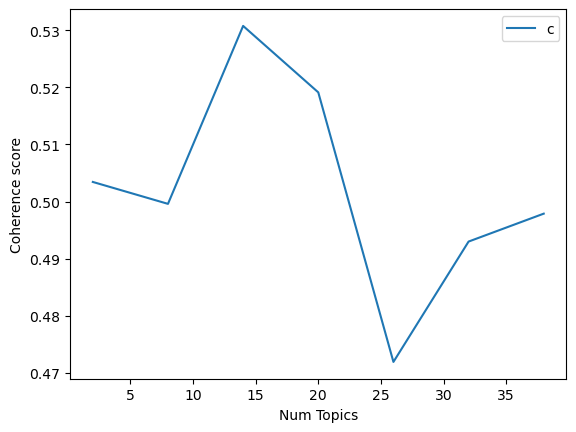

In [59]:
import matplotlib.pyplot as plt

# Show graph
limit = 40
start = 2
step = 6

# Range for topic numbers
x = range(start, limit, step)

# Plot coherence values
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [60]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.5034
Num Topics = 8  has Coherence Value of 0.4996
Num Topics = 14  has Coherence Value of 0.5308
Num Topics = 20  has Coherence Value of 0.5191
Num Topics = 26  has Coherence Value of 0.4719
Num Topics = 32  has Coherence Value of 0.493
Num Topics = 38  has Coherence Value of 0.4979


In [72]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.024*"replace" + 0.019*"problem" + 0.019*"repair" + 0.015*"engine" + '
  '0.014*"issue" + 0.012*"warranty" + 0.010*"cost" + 0.009*"oil" + 0.008*"go" '
  '+ 0.008*"own"'),
 (1,
  '0.028*"seat" + 0.014*"system" + 0.013*"get" + 0.013*"use" + 0.009*"rear" + '
  '0.009*"control" + 0.007*"front" + 0.007*"small" + 0.006*"comfortable" + '
  '0.006*"wheel"'),
 (2,
  '0.021*"get" + 0.017*"buy" + 0.014*"go" + 0.014*"problem" + 0.014*"tire" + '
  '0.013*"look" + 0.012*"maintenance" + 0.012*"use" + 0.010*"own" + '
  '0.010*"change"'),
 (3,
  '0.018*"drive" + 0.018*"look" + 0.015*"well" + 0.014*"ride" + 0.012*"own" + '
  '0.011*"feel" + 0.011*"performance" + 0.011*"get" + 0.010*"class" + '
  '0.010*"handle"'),
 (4,
  '0.049*"get" + 0.017*"fun" + 0.017*"drive" + 0.016*"gas" + 0.014*"mpg" + '
  '0.013*"mileage" + 0.012*"go" + 0.010*"diesel" + 0.009*"say" + 0.009*"look"'),
 (5,
  '0.027*"problem" + 0.022*"dealer" + 0.021*"time" + 0.017*"go" + '
  '0.016*"service" + 0.011*"month" + 0.010*"get" 

In [73]:
import pandas as pd

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = []

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df.append([int(topic_num), round(prop_topic, 4), topic_keywords])
            else:
                break

    # Convert the list to DataFrame
    sent_topics_df = pd.DataFrame(sent_topics_df, columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    
    return sent_topics_df


# Call the function with your LDA model and corpus
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format the output
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show the first 10 rows
print(df_dominant_topic.head(10))


   Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0               3              0.8995   
1            1               3              0.8124   
2            2               2              0.5816   
3            3               3              0.5822   
4            4               3              0.5020   
5            5               5              0.8600   
6            6               3              0.6790   
7            7               1              0.7055   
8            8               3              0.6008   
9            9               1              0.5462   

                                            Keywords  \
0  drive, look, well, ride, own, feel, performanc...   
1  drive, look, well, ride, own, feel, performanc...   
2  get, buy, go, problem, tire, look, maintenance...   
3  drive, look, well, ride, own, feel, performanc...   
4  drive, look, well, ride, own, feel, performanc...   
5  problem, dealer, time, go, service, month, get...   
6  drive, loo

In [74]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()



,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0,0.9847,"replace, problem, repair, engine, issue, warra...","[q5, overrated, un-reliable, purchased, q5, or..."
1,1,0.9834,"seat, system, get, use, rear, control, front, ...","[strong, silent, ride, supple, fatiguing, feel..."
2,2,0.9820,"get, buy, go, problem, tire, look, maintenance...","[""s"", pretty, expensive, loved, everything, tr..."
3,3,0.9855,"drive, look, well, ride, own, feel, performanc...","[z4, sdrive, roadster, perfect, balance, perfo..."
4,4,0.9813,"get, fun, drive, gas, mpg, mileage, go, diesel...","[s4, brings, fun, driving, s4, combination, sp..."


In [66]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics



,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,3,"drive, look, well, ride, own, feel, performanc...",3727.0,0.1167
1,3,"drive, look, well, ride, own, feel, performanc...",4325.0,0.1354
2,2,"get, buy, go, problem, tire, look, maintenance...",1864.0,0.0584
3,3,"drive, look, well, ride, own, feel, performanc...",15385.0,0.4817
4,3,"drive, look, well, ride, own, feel, performanc...",3846.0,0.1204
...,...,...,...,...
31933,4,"get, fun, drive, gas, mpg, mileage, go, diesel...",NaN,NaN
31934,5,"problem, dealer, time, go, service, month, get...",NaN,NaN
31935,4,"get, fun, drive, gas, mpg, mileage, go, diesel...",NaN,NaN
31936,5,"problem, dealer, time, go, service, month, get...",NaN,NaN


In [67]:
# Manually map the topics based on their keywords
topic_aspects = {
    0: 'safety',  
    1: 'comfort', 
    2: 'price',  
    3: 'performance',  
    4: 'fuel efficiency',  
    5: 'quality', 
}

# Assign aspects based on dominant topic
sent_topics_sorteddf_mallet['Aspect'] = sent_topics_sorteddf_mallet['Topic_Num'].map(topic_aspects)

# Show the updated dataframe
sent_topics_sorteddf_mallet.head()


,Topic_Num,Topic_Perc_Contrib,Keywords,Text,Aspect
0,0,0.9847,"replace, problem, repair, engine, issue, warra...","[q5, overrated, un-reliable, purchased, q5, or...",safety
1,1,0.9834,"seat, system, get, use, rear, control, front, ...","[strong, silent, ride, supple, fatiguing, feel...",comfort
2,2,0.9820,"get, buy, go, problem, tire, look, maintenance...","[""s"", pretty, expensive, loved, everything, tr...",price
3,3,0.9855,"drive, look, well, ride, own, feel, performanc...","[z4, sdrive, roadster, perfect, balance, perfo...",performance
4,4,0.9813,"get, fun, drive, gas, mpg, mileage, go, diesel...","[s4, brings, fun, driving, s4, combination, sp...",fuel efficiency


# aspect mapping

In [99]:
topic_aspects = {
    0: 'safety',  
    1: 'comfort', 
    2: 'price',  
    3: 'performance',  
    4: 'fuel efficiency',  
    5: 'quality', 
}

In [70]:
df_dominant_topics['Aspect'] = df_dominant_topics['Dominant_Topic'].map(topic_aspects)


In [71]:
output_path = 'data_pp_lda.csv'
df_dominant_topics.to_csv(output_path, index=False)
print(f"File saved successfully at {output_path}")


File saved successfully at topicmapping_unigram.csv
